# IA: Busca de Doadores Compat√≠veis de Sangue em Hemocentros
Este projeto implementa um prot√≥tipo de sistema para **localizar unidades de sangue compat√≠vel** dispon√≠veis para doa√ß√£o em uma cidade. A ideia central √© permitir que o usu√°rio informe seu tipo sangu√≠neo e, a partir disso, o sistema identifique o hemocentro mais pr√≥ximo com estoque suficiente para atendimento, tra√ßando a rota ideal at√© o local.

O sistema funciona da seguinte maneira:
- Um **grafo da cidade** do usu√°rio √© gerado na mem√≥ria do programa
- O sistema sabe o **tipo sangu√≠neo** do usu√°rio e calcula quais s√£o os doadores poss√≠veis
- De todos os hemocentros da cidade, **filtra** por aqueles que possuem estoque de sangue compat√≠vel
- **Tra√ßa a rota** ideal at√© esse hemocentro

## Bibliotecas utilizadas

In [1]:
import sys
import os
import osmnx as ox
import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
# Configurando paths importantes para o projeto

sys.path.append(os.path.abspath('../src'))

graphml_path = "../data/sao_carlos.graphml"
images_path = "../images/"

## Modelando o problema

### Gerando um grafo da cidade
Vamos come√ßar gerando o grafo da cidade em que nosso sistema vai rodar. No caso, escolhemos a cidade de S√£o Carlos. 

A classe `Graph` definida em `helper_functions.py` abstrai algumas funcionalidades que iremos precisar mais adiante. Vale ressaltar que existem tr√™s formatos de grafo dispon√≠veis e todos eles s√£o abstra√≠dos pela classe Graph, de modo a facilitar o entendimento deste notebook.

1. Utilizamos a biblioteca `osmnx` para gerar e salvar o grafo urbano da cidade em um arquivo .graphml, empregando dados geoespaciais reais do **OpenStreetMap**
2. Com o pr√≥prio `osmnx`, convertemos o grafo para um **GeoDataFrame (GDF)**, formato utilizado exclusivamente para visualiza√ß√£o e plotagem sobre mapas reais
3. Para executar algoritmos de busca e an√°lise de rotas, utilizamos o grafo no formato compat√≠vel com a biblioteca `networkx`, facilitando opera√ß√µes algor√≠tmicas

Vamos come√ßar instanciando o grafo e examinando visualmente seus n√≥s e arestas.

In [3]:
# Nome da cidade
cidade = "S√£o Carlos, S√£o Paulo, Brasil"

# Baixa o grafo das ruas para transporte por carro (modo drive)
G = ox.graph_from_place(cidade, network_type='drive')
ox.save_graphml(G, filepath=graphml_path)

N√∫mero de n√≥s: 9042
N√∫mero de arestas: 22340


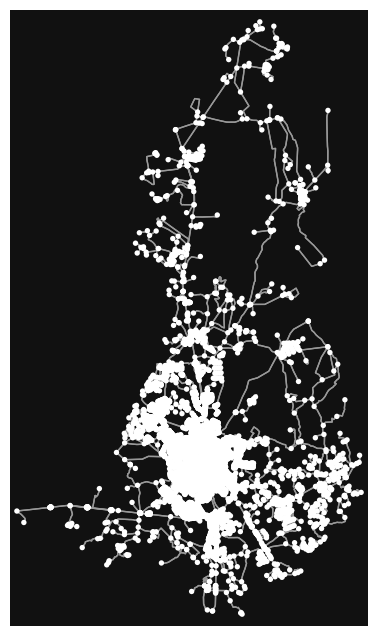

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [4]:
from utils.helper_functions import Graph

# Instanciando a classe Graph
G = Graph(graphml_path)

# Mostra informa√ß√µes do grafo
print(f"N√∫mero de n√≥s: {len(G.graph.nodes)}")
print(f"N√∫mero de arestas: {len(G.graph.edges)}")

# Desenha o grafo
ox.plot_graph(G.graph)

Essa √© a carinha do nosso grafo. Para visualiz√°-lo melhor, vamos colocar essa rede em cima do mapa real de S√£o Carlos.

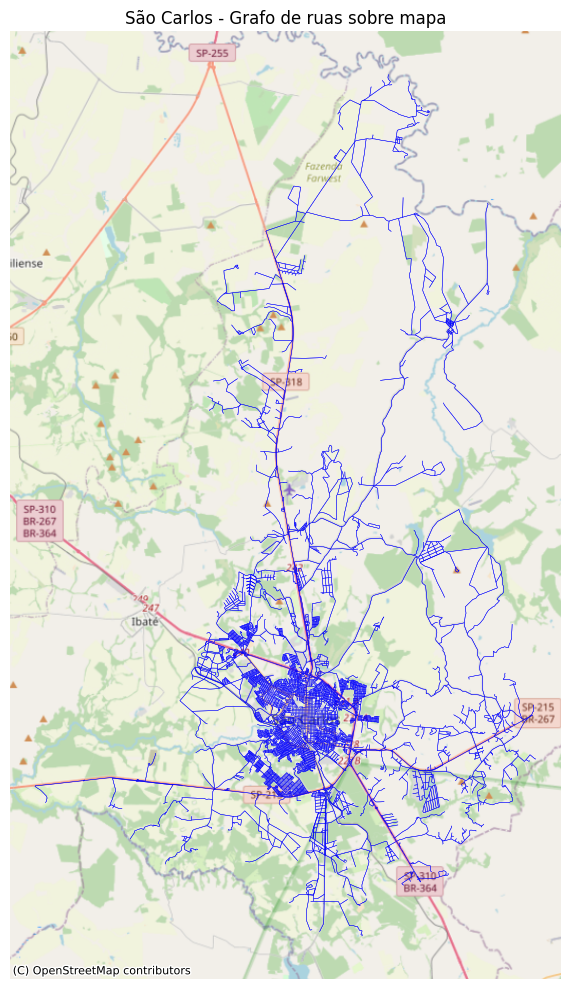

In [5]:
# Plotando as ruas de S√£o Carlos sobre o mapa da cidade
edges = G.edges_gdf

fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=0.3, edgecolor="blue")
ctx.add_basemap(ax, crs=edges.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

plt.title("S√£o Carlos - Grafo de ruas sobre mapa")
plt.tight_layout()

plt.savefig(images_path + "mapa_ruas.png", dpi=300)

plt.show()

### Definindo os Hemocentros
Agora que j√° possu√≠mos o grafo da cidade toda de S√£o Carlos, devemos definir onde ficar√£o os `Hemocentros`, que s√£o os n√≥s de interesse do nosso problema de busca (n√≥s finais). Para isso, vamos simplesmente escolher 5 n√≥s aleat√≥rios para representar os Hemocentros. Na classe `Graph` j√° existe um m√©todo implementado que retorna n n√≥s aleat√≥rios do grafo, o m√©todo `G.get_random_nodes(int n)`.

Cada n√≥ do grafo √© salvo com um ID, isto √©, uma String que o identifica. Logo, essa fun√ß√£o justamente sorteia n dentre todos os IDs aleat√≥rios, armazenados no atributo `G.graph.nodes`.

In [6]:
# Pegando 5 n√≥s aleat√≥rios para representar os hemocentros
hemocentros = G.get_random_nodes(5)
print(hemocentros)

[4976167712, 1013895246, 1030617346, 6804132764, 7120400678]


Vamos semelhantemente ao caso anterior plotar os hemocentros sobre o mapa de S√£o Carlos, a fim de obter uma melhor visualiza√ß√£o dos nossos dados. Os c√≠rculos vermelhos no mapa representar√£o a localiza√ß√£o dos hemocentros.

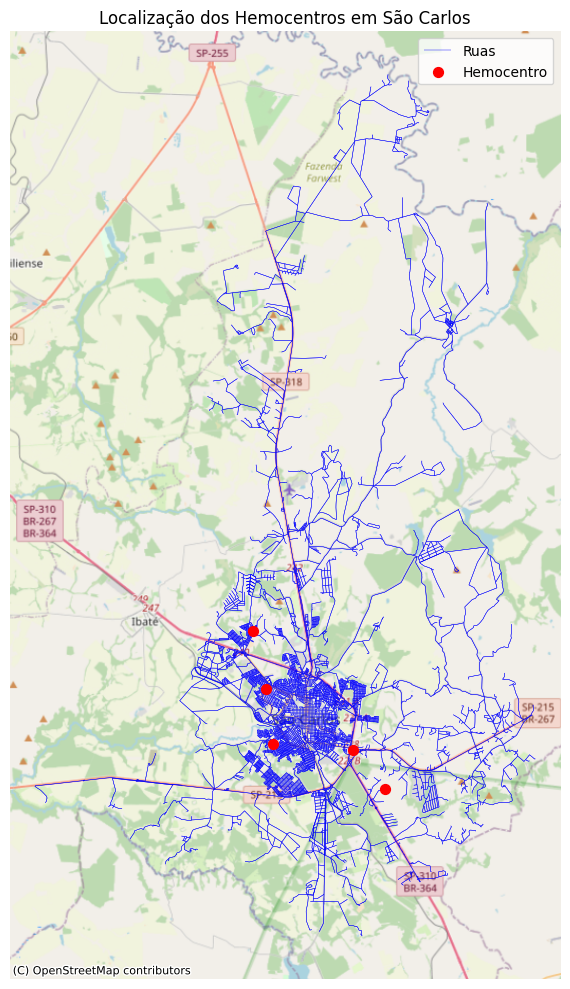

In [7]:
# Convertendo os hemocentros para GDF (somente para poder plotar)
gdf_hemocentros = G.get_gdf_nodes(hemocentros)

# Plotando o mapa
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=0.3, edgecolor="blue", label='Ruas')
gdf_hemocentros.plot(ax=ax, color="red", markersize=50, zorder=3, label='Hemocentro')
ctx.add_basemap(ax, crs=edges.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

plt.legend()
plt.title("Localiza√ß√£o dos Hemocentros em S√£o Carlos")
plt.tight_layout()

plt.savefig(images_path + "mapa_ruas_hcs.png", dpi=300)

plt.show()

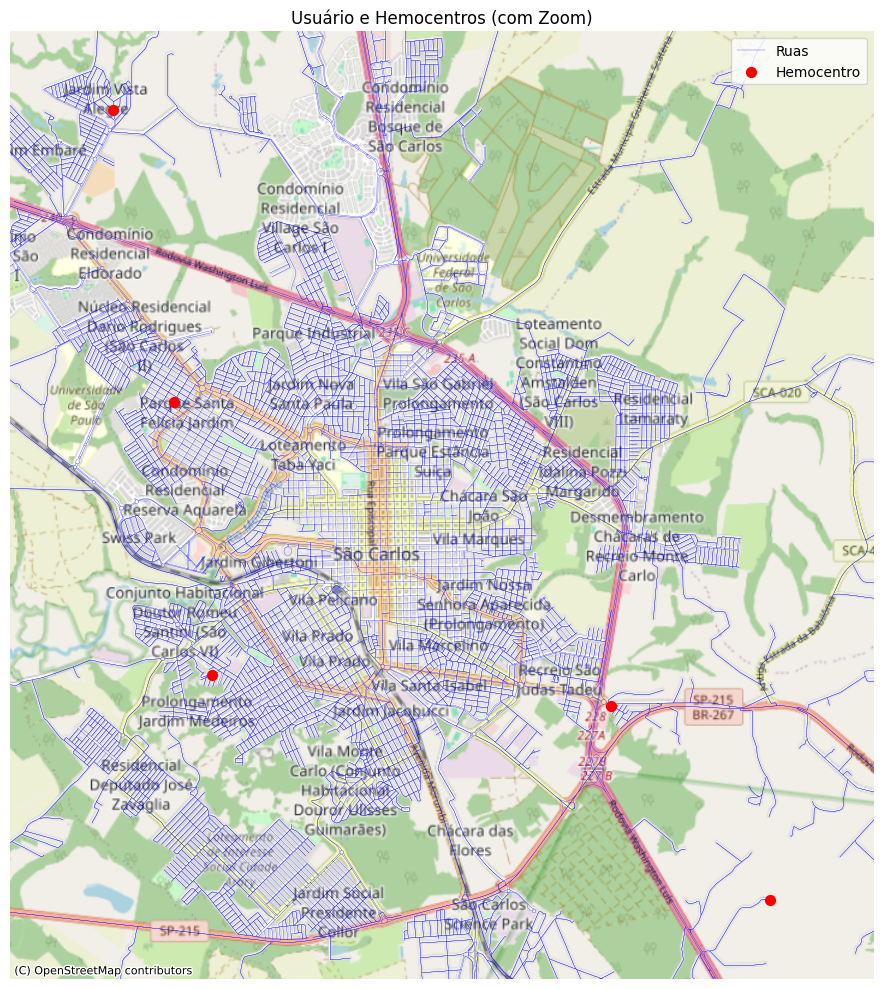

In [8]:
from utils.helper_functions import plotar_com_zoom
plotar_com_zoom(None, gdf_hemocentros, edges, name="mapa_ruas_hcs_zoom.png")

Precisamos ainda definir o estoque de determinado tipo sangu√≠neo em cada um dos hemocentros. Para isso, vamos usar uma outra classe definida em `helper_functions.py`, a classe `BancoDeHemocentros`. Essa classe abstrai todo o estoque de bolsas de sangue de todos os hemocentros da cidade de S√£o Carlos (ou de qualquer cidade que utilize o sistema). Logo, nossa vari√°vel `H` ser√° a representande de todo o banco de dados dos hemocentros da cidade em quest√£o.

In [9]:
from utils.helper_functions import BancoDeHemocentros

# Instanciando o banco de hemocentros
H = BancoDeHemocentros(hemocentros, G.graph)

# Exemplo, estoque de bolsas de sangue um √∫nico hemocentro
H.consultar_estoque(hemocentros[0])

{'A+': 0, 'A-': 0, 'B+': 48, 'B-': 0, 'AB+': 36, 'AB-': 47, 'O+': 47, 'O-': 0}

### Localiza√ß√£o do Usu√°rio
Agora, que temos os hemocentros dipostos aleatoriamente, precisamos definir a localiza√ß√£o do n√≥ inicial, ou seja, da localiza√ß√£o atual do usu√°rio do sistema. Vamos tamb√©m gerar uma localiza√ß√£o aleat√≥ria para representar o ponto de partida do grafo.

In [10]:
user = G.get_random_nodes(1)
print(user)

[1033189645]


In [ ]:
# Converte o ID em GDF (para plotar)
gdf_user = G.get_gdf_nodes(user)

# Plotando o mapa com a localiza√ß√£o aleat√≥ria
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=0.3, edgecolor="blue", label='Ruas')
gdf_hemocentros.plot(ax=ax, color="red", markersize=50, zorder=3, label='Hemocentro')
gdf_user.plot(ax=ax, color="chartreuse", markersize=150, zorder=3, label='Localiza√ß√£o do Usu√°rio')

ctx.add_basemap(ax, crs=edges.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

plt.legend()
plt.title("Localiza√ß√£o do Usu√°rio e Hemocentros de S√£o Carlos")
plt.tight_layout()

plt.savefig(images_path + "mapa_ruas_hcs_user.png", dpi=300)

plt.show()

In [ ]:
plotar_com_zoom(gdf_user, gdf_hemocentros, edges, map=False, name="ruas_hcs_user_zoom.png")

## Buscas: BFS e A*
As duas buscas implementadas para solucionar o problema s√£o a Busca em Largura (ou Breadth-First Search) e o algoritmo A* (A-Estrela). 

Antes de executar as buscas, o sistema deve ser capaz de identificar atrav√©s do banco de dados quais hemocentros possuem os tipos sangu√≠neos doadores compat√≠veis com o do usu√°rio. Assim, deve-se filtrar os hemocentros que n√£o atendem √†s necessidades antes de realizar a busca.

In [ ]:
# Definindo o tipo de sangue do usu√°rio e filtrando os HCs v√°lidos
blood_type = "O-"
hcs_validos = H.hemocentros_validos(blood_type)

print(hcs_validos)

Estes IDs acima s√£o os n√≥s dos hemocentros v√°lidos, isto √©, aqueles que possuem estoque de sangue compat√≠vel com o usu√°rio para realizar a doa√ß√£o. Perceba que o n√∫mero de hemocentros v√°lidos √© menor ou igual ao n√∫mero de todos os hemocentros da cidade, pois nem todos eles tem sangue compat√≠vel com nosso usu√°rio.

Vamos visualizar (com zoom) a localiza√ß√£o dos hemocentros compat√≠veis, em rela√ß√£o √† localiza√ß√£o do usu√°rio do sistema.

In [ ]:
# Juntando os pontos que queremos enquadrar
gdf_hcs_validos = G.get_gdf_nodes(hcs_validos)

plotar_com_zoom(gdf_user, gdf_hcs_validos, edges, valid=True, map=False, name="ruas_hcsvalidos_user_zoom.png")

Agora que o sistema sabe todas as informa√ß√µes pertinentes, vamos realizar as buscas de fato.

### Busca n√£o informada: BFS (Breadth-First Search)
A Busca em Largura √© a mais adequada quando o assunto √© salvar vidas. Nesse problema, n√£o estamos interessados em qualquer caminho, e sim no mais curto, ou nos mais curtos. 

No entanto, sabemos que, diferentemente de algoritmos que levam pesos e heur√≠sticas em considera√ß√£o, no BFS n√£o somos capazes de dizer se de fato estamos percorrendo a menor dist√¢ncia! Isso parece contraintuitivo, mas na verdade √© bem n√≠tido.

O BFS encontrar√° o menor caminho em termos de arestas percorridas, mas isso n√£o necessariamente garantir√° que ser√° a menor dist√¢ncia, j√° que n√£o consideramos o peso das arestas. Considera√ß√µes nessa estirpe n√£o s√£o resolvidas aqui, mas ser√£o feitas no algoritmo A*.

Criamos o arquivo `busca_nao_informada.py`, que cont√©m a implementa√ß√£o da busca em largura, a partir da fun√ß√£o `rota_bfs` que ir√°:

- Receber o grafo
- Receber um n√≥ de origem
- Receber uma lista de n√≥s de destino (v√°rios hemocentros compat√≠veis)
- Retornar o primeiro caminho mais curto at√© algum deles

In [ ]:
from algorithms.busca_nao_informada import bfs

rota_bfs = bfs(G.graph, user[0], hcs_validos)

if rota_bfs:
    G.plotar_rota(rota_bfs, name="rota_bfs.png")

else:
    print("Nenhum hemocentro acess√≠vel foi encontrado.")

A seguir, faremos uma compara√ß√£o entre a nossa implementa√ß√£o da BFS e o algoritmo padr√£o da biblioteca `networkx`, que faz uma busca cuja pondera√ß√£o √© baseada no peso "length", que s√£o as dist√¢ncias em metros mesmos fornecidas pelo `osmnx`. A vari√°vel `rota_curta` √© de fato a rota mais curta em metros, enquanto `rota_bfs` √© a rota mais curta em n√∫mero de arestas.

In [ ]:
# Calcula rota √≥tima com menor dist√¢ncia em metros (j√° usa weight='length')
rota_curta = G.calcular_rota(user[0], rota_bfs[-1])  # usa nx.shortest_path com peso

# Lembre-se: rota_bfs[-1] √© o √∫ltimo elemento dessa lista, ou seja, o n√≥ final

# Mostra quantos n√≥s foram usados em cada rota
print(f"üî¥ Rota BFS: {len(rota_bfs)} n√≥s")
print(f"üü¢ Rota com menor dist√¢ncia (curta): {len(rota_curta)} n√≥s\n")

# Comparando as rotas
# Comparar os caminhos ou dist√¢ncias totais percorridas
distancia_curta = G.calcular_distancia(user[0], rota_bfs[-1])

distancia_bfs = 0
for i in range(len(rota_bfs) - 1):
    u, v = rota_bfs[i], rota_bfs[i + 1]
    
    # Verifica se a aresta existe no grafo
    if G.graph.has_edge(u, v):
        edge_data = G.graph[u][v]  # Pega os dados da aresta
        # Acessa o comprimento da aresta
        length = edge_data[0].get('length', 0)  # Caso n√£o tenha 'length', assume 0
        distancia_bfs += length
    else:
        print(f"Aresta entre {u} e {v} n√£o encontrada no grafo.")

# Imprime as dist√¢ncias totais das rotas
print(f"üî¥ Dist√¢ncia total BFS: {distancia_bfs} metros")
print(f"üü¢ Dist√¢ncia total da rota curta: {distancia_curta} metros\n")

# Compara se as rotas s√£o iguais ou diferentes
if rota_bfs == rota_curta:
    print("‚úÖ BFS encontrou a mesma rota da menor dist√¢ncia (coincid√™ncia rara).")
else:
    print("‚ö†Ô∏è BFS encontrou uma rota diferente da mais curta em dist√¢ncia ‚Äî esperado!")

Olha que interessante!

O resultado acima mostra que a rota BFS, que encontra a solu√ß√£o que passa por menos arestas (isto √©, d√° menos saltos) n√£o coincide com a solu√ß√£o que √© de fato, mais curta, em termos de dist√¢ncia (em metros mesmo!). Isso era de se esperar e mostra de maneira cabal que essa busca BFS, assim como a DFS (buscas n√£o informadas no geral) n√£o s√£o adequadas para esse problema, que lida com vidas humanas.

### Busca Informada: A* (A-Star)
O algoritmo A* (A-Estrela) de busca em grafos √© um tipo de busca informada, no qual utiliza-se de uma heur√≠stica para avaliar o qu√£o mais pr√≥ximo estamos do destino final. Vale ressaltar que a heur√≠stica √© uma estimativa, que guia a tomada de decis√£o do algoritmo.

O algoritmo funciona da seguinte forma:


$f(n) = g(n) + h(n)$


- **f(n)**: custo total estimado do caminho passando pelo n√≥ `n`
- **g(n)**: custo real do caminho do in√≠cio at√© `n`
- **h(n)**: custo estimado de `n` at√© o destino (heur√≠stica)

Ele percorre o grafo buscando sempre os menores valores de $f(n)$, at√© que encontre um n√≥ final. No caso de mapas ou grafos espaciais (como ruas), a heur√≠stica mais usada √© a **dist√¢ncia euclidiana ou geod√©sica** (haversine) entre os pontos. Esta √© justamente a heur√≠stica que iremos utilizar!

In [ ]:
from algorithms.busca_informada import a_estrela

rota_a_estrela = a_estrela(G.graph, user[0], hcs_validos)

if rota_a_estrela:
    G.plotar_rota(rota_a_estrela, name="rota_astar.png")

else:
    print("Nenhum hemocentro acess√≠vel foi encontrado.")

In [ ]:
# Calcula rota √≥tima com menor dist√¢ncia em metros (j√° usa weight='length')
rota_curta = G.calcular_rota(user[0], rota_a_estrela[-1])  # usa nx.shortest_path com peso 'length'

# Mostra quantos n√≥s foram usados em cada rota
print(f"üî¥ Rota A*: {len(rota_a_estrela)} n√≥s")
print(f"üü¢ Rota com menor dist√¢ncia (curta): {len(rota_curta)} n√≥s\n")

# Comparando as rotas
# Comparar os caminhos ou dist√¢ncias totais percorridas
distancia_curta = G.calcular_distancia(user[0], rota_a_estrela[-1])

# Calcula a dist√¢ncia total da rota A* somando o comprimento de cada aresta
distancia_a_estrela = 0
for i in range(len(rota_a_estrela) - 1):
    u, v = rota_a_estrela[i], rota_a_estrela[i + 1]
    
    # Verifica se a aresta existe no grafo
    if G.graph.has_edge(u, v):
        edge_data = G.graph[u][v]  # Pega os dados da aresta
        # Acessa o comprimento da aresta
        length = edge_data[0].get('length', 0)  # Caso n√£o tenha 'length', assume 0
        distancia_a_estrela += length
    else:
        print(f"Aresta entre {u} e {v} n√£o encontrada no grafo.")

# Imprime as dist√¢ncias totais das rotas
print(f"üî¥ Dist√¢ncia total A*: {distancia_a_estrela} metros")
print(f"üü¢ Dist√¢ncia total da rota curta: {distancia_curta} metros\n")

# Compara se as dist√¢ncias totais s√£o iguais ou diferentes
if distancia_a_estrela == distancia_curta:
    print("‚úÖ A* encontrou a mesma rota da menor dist√¢ncia (esperado).")
else:
    print("‚ö†Ô∏è A* encontrou uma rota diferente da mais curta ‚Äî inesperado (ou heur√≠stica n√£o admiss√≠vel).")